In [2]:
import os
import sys
import time
import argparse
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.optimizers as optimizers
import chainer.serializers as serializers
from chainer import cuda
import numpy as np
import cupy
import matplotlib.pyplot as plt
from IPython import display

import models
import nn
import utils

In [18]:
lh_static = np.load('./Model/Loss/GL_32_0600_train_loss.npy')[2]
lt_opt    = np.load('./SiyuCube/Loss/NoAug_GL_32_0600_train_loss.npy')

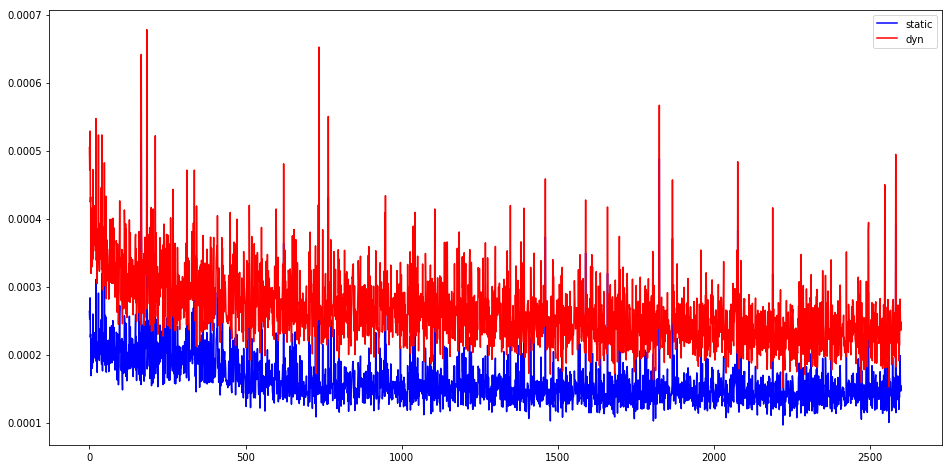

In [20]:
plt.close('all')
plt.figure(figsize=(16,8))
plt.plot(lh_static[400:], c='b',label='static')
plt.plot(lt_opt[400:], c='r', label='dyn')
plt.legend()
display.display(plt.gcf())
display.clear_output(wait=True)

In [15]:
np.median(lt_opt[-150:])

0.00023025835253065452

In [3]:
# static vars
#RNG_SEEDS     = [98765, 12345, 319, 77743196] # takes too long
#RNG_SEEDS     = [98765, 12345, 77743196] 
RNG_SEED = 77743196
BOUND         = 0.095
LEARNING_RATE = 0.01
GRAPH_CHANNELS = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
SET_CHANNELS   = [6, 32, 128, 256, 128, 32, 256, 16, 3]
CHANNELS     = {0:SET_CHANNELS, 1:GRAPH_CHANNELS, 2:None}
NBODY_MODELS = {0:models.SetModel, 1:models.GraphModel, 2:models.VelocityScaled}
MTAGS        = {0:'S', 1:'G', 2:'V'}
RS_TO_FLOAT  {'32_0600':(32,0.6,0.0),'32_0400':(32,0.4,0.0),'32_0800':(32,0.8,0.0),'32_0600':(32,1.0,0.0),}

In [ ]:
def make_cubes(model, xinput, xtruth, save=True):
    return 2

def load_model(mname):
    tag = mname[:2]
    if tag[0] == 'G':
        mtype = models.GraphModel
        if tag[1] == 'L':
            #XL_32_0600_...
            #0123456789
            theta_key = RS_TO_FLOAT[tag[3:10]]
            theta = THETAS[theta_key] # mname 6:10 have redshift in string
    keymap = {'G_': {'model': models.GraphModel, 'channels':}}

In [5]:
'''
Load data, make validation cubes
'''
MODEL_DIR = './Model/'
SAVE_DIR = './cubes/'
TH = np.load('thetas_timesteps.npy').item()
# redshifts 06 00
G_32_0600  = serializers.load_npz(MODEL_DIR + 'G_32_0600_77743196.model', models.GraphModel(GRAPH_CHANNELS)) # _77743196 best
GL_32_0600 = serializers.load_npz(MODEL_DIR + 'GL_32_0600_77743196.model', models.GraphModel(GRAPH_CHANNELS, theta=TH[(32,0.6,0.0)])) # _77743196 best
S_32_0600  = serializers.load_npz(MODEL_DIR + 'S_32_0600_98765.model', models.SetModel(SET_CHANNELS)) # _98765 best
SL_32_0600  = serializers.load_npz(MODEL_DIR + 'SL_32_0600_98765.model', models.SetModel(SET_CHANNELS, theta=TH[(32,0.6,0.0)])) # _98765 best
V_32_0600  = serializers.load_npz(MODEL_DIR + 'V_32_0600_98765.model', models.VelocityScaled()) # _98765

# redshifts 04 00
GL_32_0400 = serializers.load_npz(MODEL_DIR + 'GL_32_0400_77743196.model', models.GraphModel(GRAPH_CHANNELS, theta=TH[(32,0.4,0.0)])) # _77743196 best
SL_32_0400  = serializers.load_npz(MODEL_DIR + 'SL_32_0600_98765.model', models.SetModel(SET_CHANNELS, theta=TH[(32,0.6,0.0)])) # _98765 best
V_32_0400  = models.VelocityScaled() # _98765

# redshifts 08 00
GL_32_0800 = models.GraphModel(GRAPH_CHANNELS) # _77743196 best
SL_32_0800 = models.SetModel(SET_CHANNELS) # 77743196_
V_32_0800  = models.VelocityScaled() # _98765

# redshifts 10 00
GL_32_1000 = models.GraphModel(GRAPH_CHANNELS) # _77743196 best
SL_32_1000 = models.SetModel(SET_CHANNELS) # 77743196_
V_32_1000  = models.VelocityScaled() # _98765

In [7]:
def seed_rng(s=12345):
    np.random.seed(s)
seed_rng()

num_particles = 16
zX, zY = 0.6, 0.0
COEFF = np.load('./thetas_timesteps.npy').item()

In [4]:
X, Y = data_utils.load_data(num_particles, zX, zY, normalize_data=True)

In [5]:
x10 = X[:10]

In [72]:
'''
Rotate stuff
'''
def rotate_x(sin_t, cos_t, x, y, z):
    out_x = x
    out_y = cos_t * y - sin_t * z
    out_z = sin_t * y + cos_t * z
    return out_x, out_y, out_z

def rotate_y(sin_t, cos_t, x, y, z):
    out_x = cos_t * x + sin_t * z
    out_y = y
    out_z = -sin_t * x + cos_t * z
    return out_x, out_y, out_z

def rotate_z(sin_t, cos_t, x, y, z):
    out_x = cos_t * x - sin_t * y
    out_y = sin_t * x + cos_t * y
    out_z = z
    return out_x, out_y, out_z
    
def rotate_3D(thetas, input_data):
    """ Rotate data by random theta
    thetas and input_data will be split by D axis, each retaining it's split
    axis dim (1,)
    sin, cos are performed once at the caller level, and the callee rotate
    functions only perform the rotational algebra
    
    Args:
        thetas     (ndarray): (mb_size, 3) random numbers for rotation
        input_data (ndarray): (mb_size, n_P, 3) data to be rotated
    """
    xp = chainer.cuda.get_array_module(input_data) # xp either numpy or cupy, based on GPU usage
    thetas = xp.expand_dims(thetas, -1)
    
    idx = [1,2]
    xyz = xp.split(input_data, idx, axis=-1) # len 3 list, each of shape (mb_size, n_P, 1)    
    sin_t = xp.split(xp.sin(thetas), idx, axis=1) # len 3 list, each of shape (mb_size, 1, 1)
    cos_t = xp.split(xp.cos(thetas), idx, axis=1)
    
    rotated_z   = rotate_z(sin_t[0], cos_t[0], *xyz)
    rotated_yz  = rotate_y(sin_t[1], cos_t[1], *rotated_z)
    rotated_xyz = rotate_x(sin_t[2], cos_t[2], *rotated_yz)
    out_data = xp.concatenate(rotated_xyz, axis=-1)
    return out_data

def rotate_data(thetas, input_data):
    """ Randomly rotate data by theta
    This function is redundant. No need to call rotate_3D twice if we 
    spend a little more time on indexing, but for now it stays
    """
    xp = chainer.cuda.get_array_module(input_data) # xp either numpy or cupy, based on GPU usage
    rotated_coo = rotate_3D(thetas, input_data[...,:3])
    rotated_vel = rotate_3D(thetas, input_data[...,3:])
    return xp.concatenate((rotated_coo, rotated_vel), axis=-1)    

In [71]:
mb_size = 10
theta = np.random.randn(10,3)
######
x10coo_rotated = rotate_3D(theta, x10[...,:3])
x10vel_rotated = rotate_3D(theta, x10[...,3:])
x10_rotated = rotate_data(theta, x10)
assert np.all(x10coo_rotated == x10_rotated[...,:3]) and np.all(x10vel_rotated == x10_rotated[...,3:])

In [44]:
theta = np.expand_dims(theta, 1)
cos_t = np.cos(theta)
sin_t = np.sin(theta)
sin_t.shape

(10, 1, 3)

In [45]:
outy = cos_t[:,:,1] * x10[...,1] - sin_t[:,:,2] * x10[...,2]

In [46]:
outy.shape

(10, 4096)

In [18]:
theta_exp1 = F.expand_dims(theta, 1)
outx  = F.expand_dims(x10[...,0], 2)
sin_t = F.sin(theta_exp1)
cos_t = F.cos(theta_exp1)

In [22]:
outx.shape

(10, 4096, 1)

In [4]:
#=============================================================================
# Training and model params
#=============================================================================
use_gpu = True
xp = cupy if use_gpu == 1 else np
mb_size   = 8 # 8
num_iters = 2000 # 3000
num_particles = 32
zX, zY = 0.6, 0.0
model_type = 1 # {0:set, 1:graph, 2:vel}
mtype  = NBODY_MODELS[model_type]
channels = CHANNELS[model_type]
mname  = ''
theta = None
use_theta = 0
save_label = data_utils.get_save_label(mname, MTAGS[model_type], use_theta, num_particles, zX, zY)
if use_theta == 1:
    thetas = np.load('./thetas_timesteps.npy').item()
    theta_val = thetas[(num_particles, zX, zY)]['W']
    theta = theta_val

model_dir = './testing/'
loss_path = model_dir + 'Loss/'
if not os.path.exists(loss_path): os.makedirs(loss_path)
    
def seed_rng(s=12345):
    np.random.seed(s)
    xp.random.seed(s)
seed_rng()
print('Training {}, save: {}'.format(save_label, model_dir))

Training G_32_0400_, save: ./testing/


In [4]:
#=============================================================================
# Load data
#=============================================================================
if (zX, zY) == (0.6, 0.0) and num_particles == 32:
    X = np.load('X32_0600.npy')
    Y = np.load('Y32_0600.npy')
else:
    X, Y = data_utils.load_data(num_particles, zX, zY, normalize_data=True)

if use_gpu:
    X = cuda.to_gpu(X)
    Y = cuda.to_gpu(Y)
X_tup, Y_tup = data_utils.split_data_validation(X,Y, num_val_samples=200)
X_train, X_val = X_tup
Y_train, Y_val = Y_tup
print('X_train.shape: {}'.format(X_train.shape))

X_train.shape: (800, 4096, 6)


In [5]:
#=============================================================================
# Loss history
#=============================================================================
train_loss_history = np.zeros((num_iters))
num_val_batches = X_val.shape[0] // mb_size
validation_loss_history = np.zeros((num_val_batches))

In [15]:
#=============================================================================
# Init model and opt
#=============================================================================
model_save_label = save_label + '{}_'.format(RNG_SEED)
print('model tag: {}'.format(model_save_label))
seed_rng(RNG_SEED)
model = mtype(channels, theta=theta)
if use_gpu: model.to_gpu()
optimizer = optimizers.Adam(alpha=LEARNING_RATE)
optimizer.setup(model)

model tag: G_16_0400_77743196_


KeyboardInterrupt: 

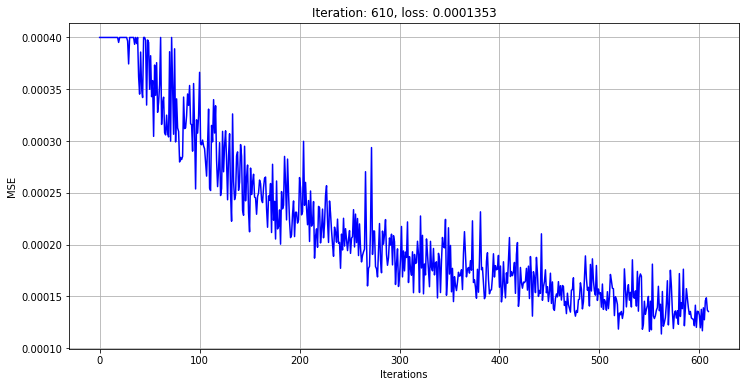

In [16]:
# train loop
for cur_iter in range(num_iters):
    model.zerograds() # must always zero grads before another forward pass!
    
    # create mini-batches for training
    _x_in, _x_true = data_utils.next_minibatch([X_train, Y_train], mb_size)
    x_in, x_true = chainer.Variable(_x_in), chainer.Variable(_x_true)
    
    # get prediction and loss
    x_hat = model(x_in, add=True) # prediction
    loss = nn.get_bounded_MSE(x_hat, x_true, boundary=BOUND) # bound = 0.095                
    #loss, loc_loss, vel_loss = nn.get_bounded_MSE_vel(x_hat, x_true, boundary=BOUND) # bound = 0.095
    
    # backprop and update
    loss.backward() # this calculates all the gradients (backprop)
    optimizer.update() # this updates the weights
    
    train_loss_history[cur_iter] = cuda.to_cpu(loss.data)
    if cur_iter % 10 == 0 and cur_iter != 0:
        y = train_loss_history[:cur_iter]
        plt.close('all')
        fig = data_utils.plot_training_curve(y, cur_iter, yclip=0.0004)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)

np.save(loss_path + save_label + 'train_loss', train_loss_history)
#print('{}: converged at {}'.format(model_save_label, np.median(lh_train[-150:])))
# save model, optimizer
data_utils.save_model([model, optimizer], model_dir + model_save_label)

In [22]:
# validation
with chainer.using_config('train', False):
    for val_iter in range(num_val_batches):
        j,k = val_iter * mb_size, (val_iter+1) * mb_size
        _val_in, _val_true = X_val[j:k], Y_val[j:k]
        val_in, val_true = chainer.Variable(_val_in), chainer.Variable(_val_true)
        
        val_hat  = model(val_in, add=True)
        val_loss = nn.mean_squared_error(val_hat, val_true, boundary=BOUND)
        validation_loss_history[val_iter] = cuda.to_cpu(val_loss.data)
        print('{:<3}: {:.8}'.format(val_iter, validation_loss_history[val_iter]))
    np.save(loss_path + save_label + 'val_loss', validation_loss_history)
    print('{}: validation avg {}'.format(model_save_label, np.mean(validation_loss_history)))

0  : 0.00013075116
1  : 0.00013182613
2  : 0.00011922169
3  : 0.00017336106
4  : 0.00012016048
5  : 0.00012035463
6  : 0.00012243852
7  : 0.00013374194
8  : 0.00010367872
9  : 0.00011797337
10 : 0.00012032747
11 : 0.00010863714
12 : 0.00014265404
13 : 0.00012265178
14 : 0.00013835019
15 : 0.00013226883
16 : 0.00013287264
17 : 0.00012656767
18 : 0.00014756095
19 : 0.00012954464
20 : 0.00011920968
21 : 0.00011802647
22 : 0.00013869027
23 : 0.0001281904
24 : 0.00012771031
G_16_0400_77743196_: validation avg 0.00012827080732677132


In [13]:
xh = cuda.to_cpu(x_hat.data)
xt = cuda.to_cpu(x_true.data)

In [3]:
rscube_dir = './MultiCubes/Cubes/'
RS_x_input = np.load(rscube_dir + 'X_32_data.npy') # (11, 200, 32768, 6)
RS_x_pred  = np.load(rscube_dir + 'TestX32_6.0-0.0_predictions.npy') # (10, 200, 32768, 6)

In [4]:
xt = RS_x_input[-1]
xh = RS_x_pred[-1]

In [14]:
xh.shape

(200, 32768, 6)

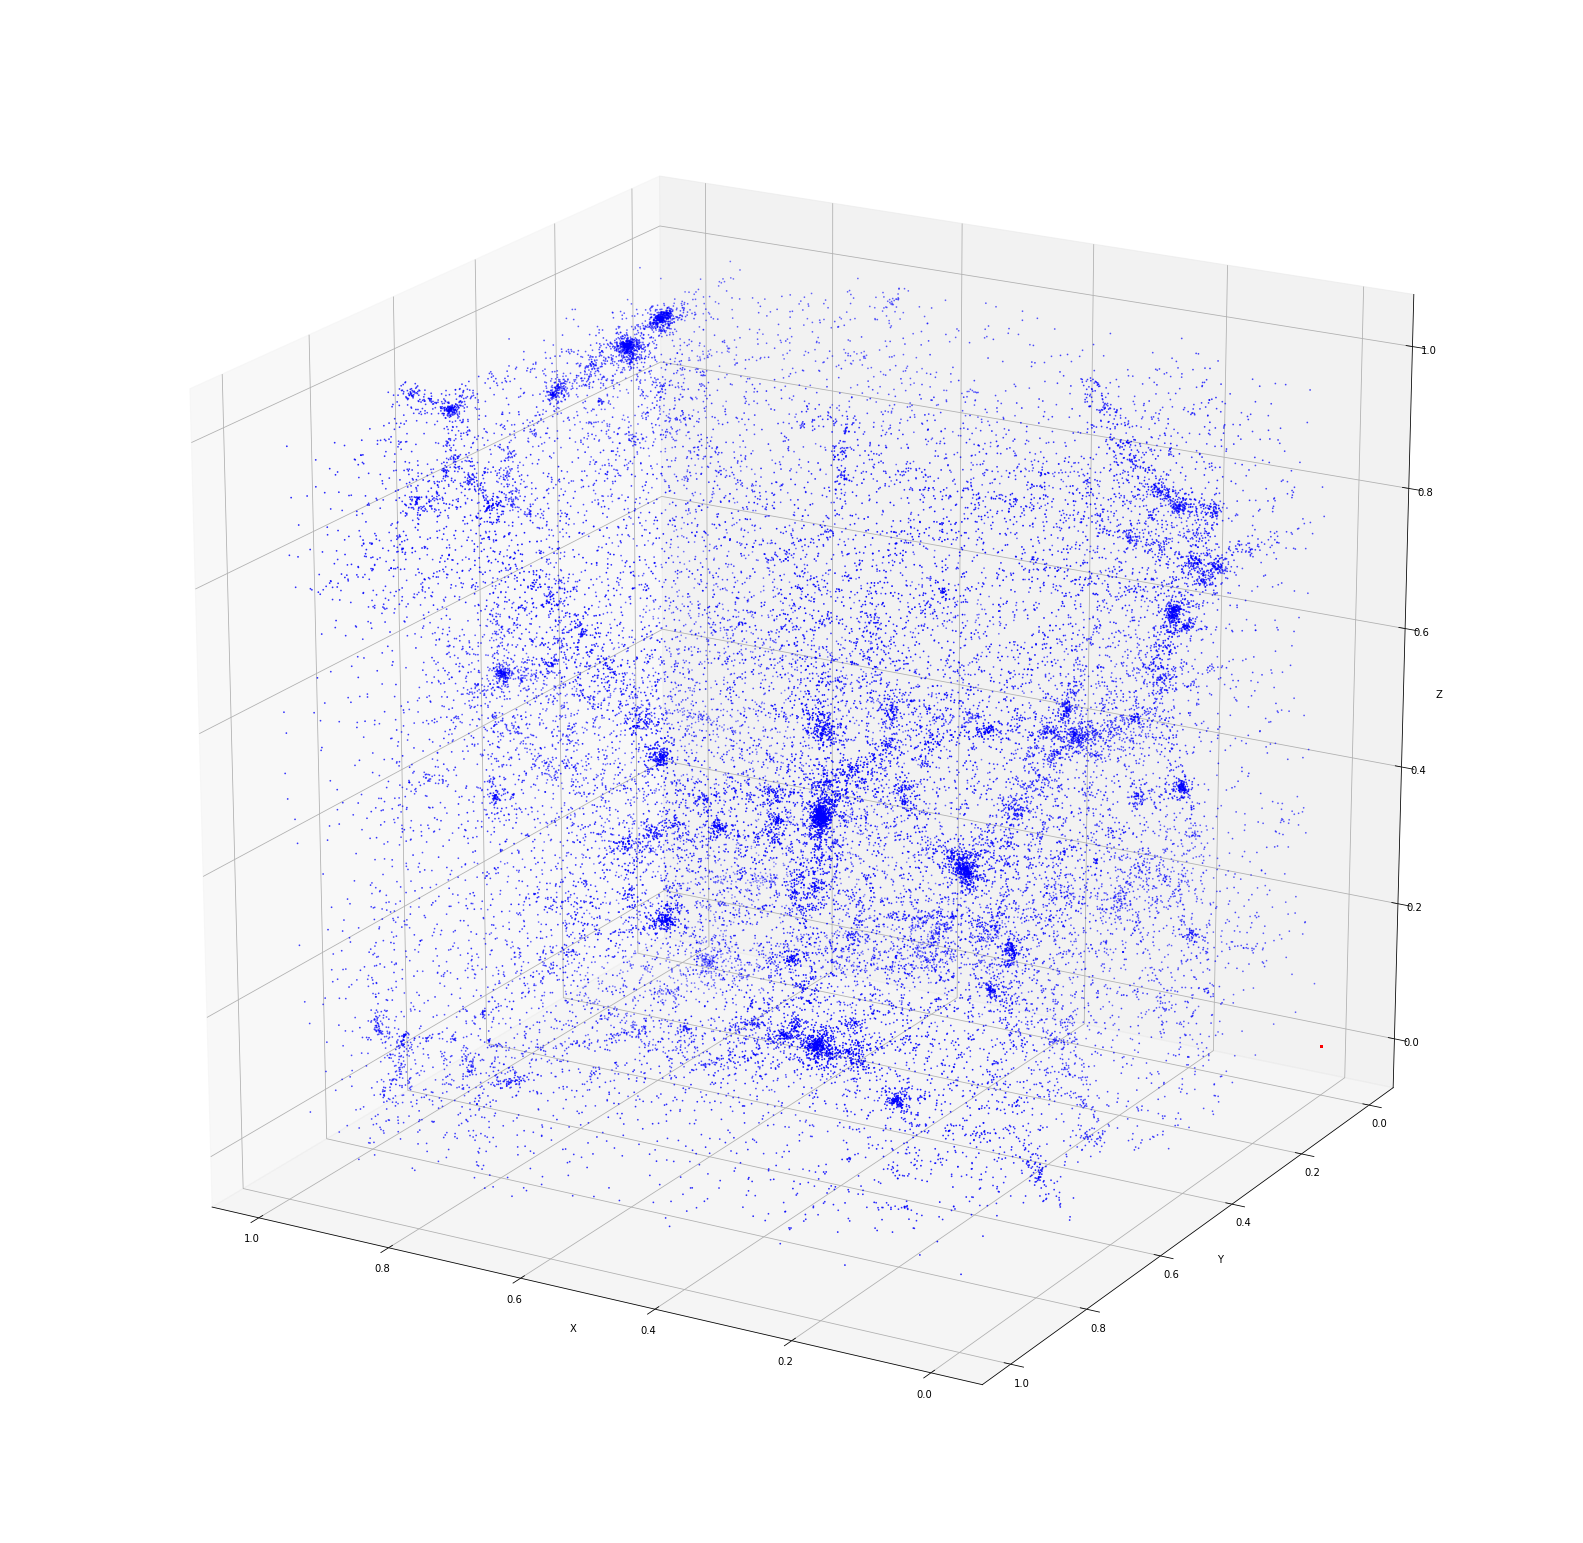

In [6]:
'''
plot point cloud
'''
from IPython import display
j = 19
fsize = (28,28)
particle_size = (.6, 1.3)
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = data_utils.plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image

In [11]:
data_dir = './SiyuCube/Cubes/'
xh2  = np.load(data_dir + 'X32_6.0-0.0_prediction.npy')
xt2 = np.load(data_dir + 'X_32_0.0_data.npy')

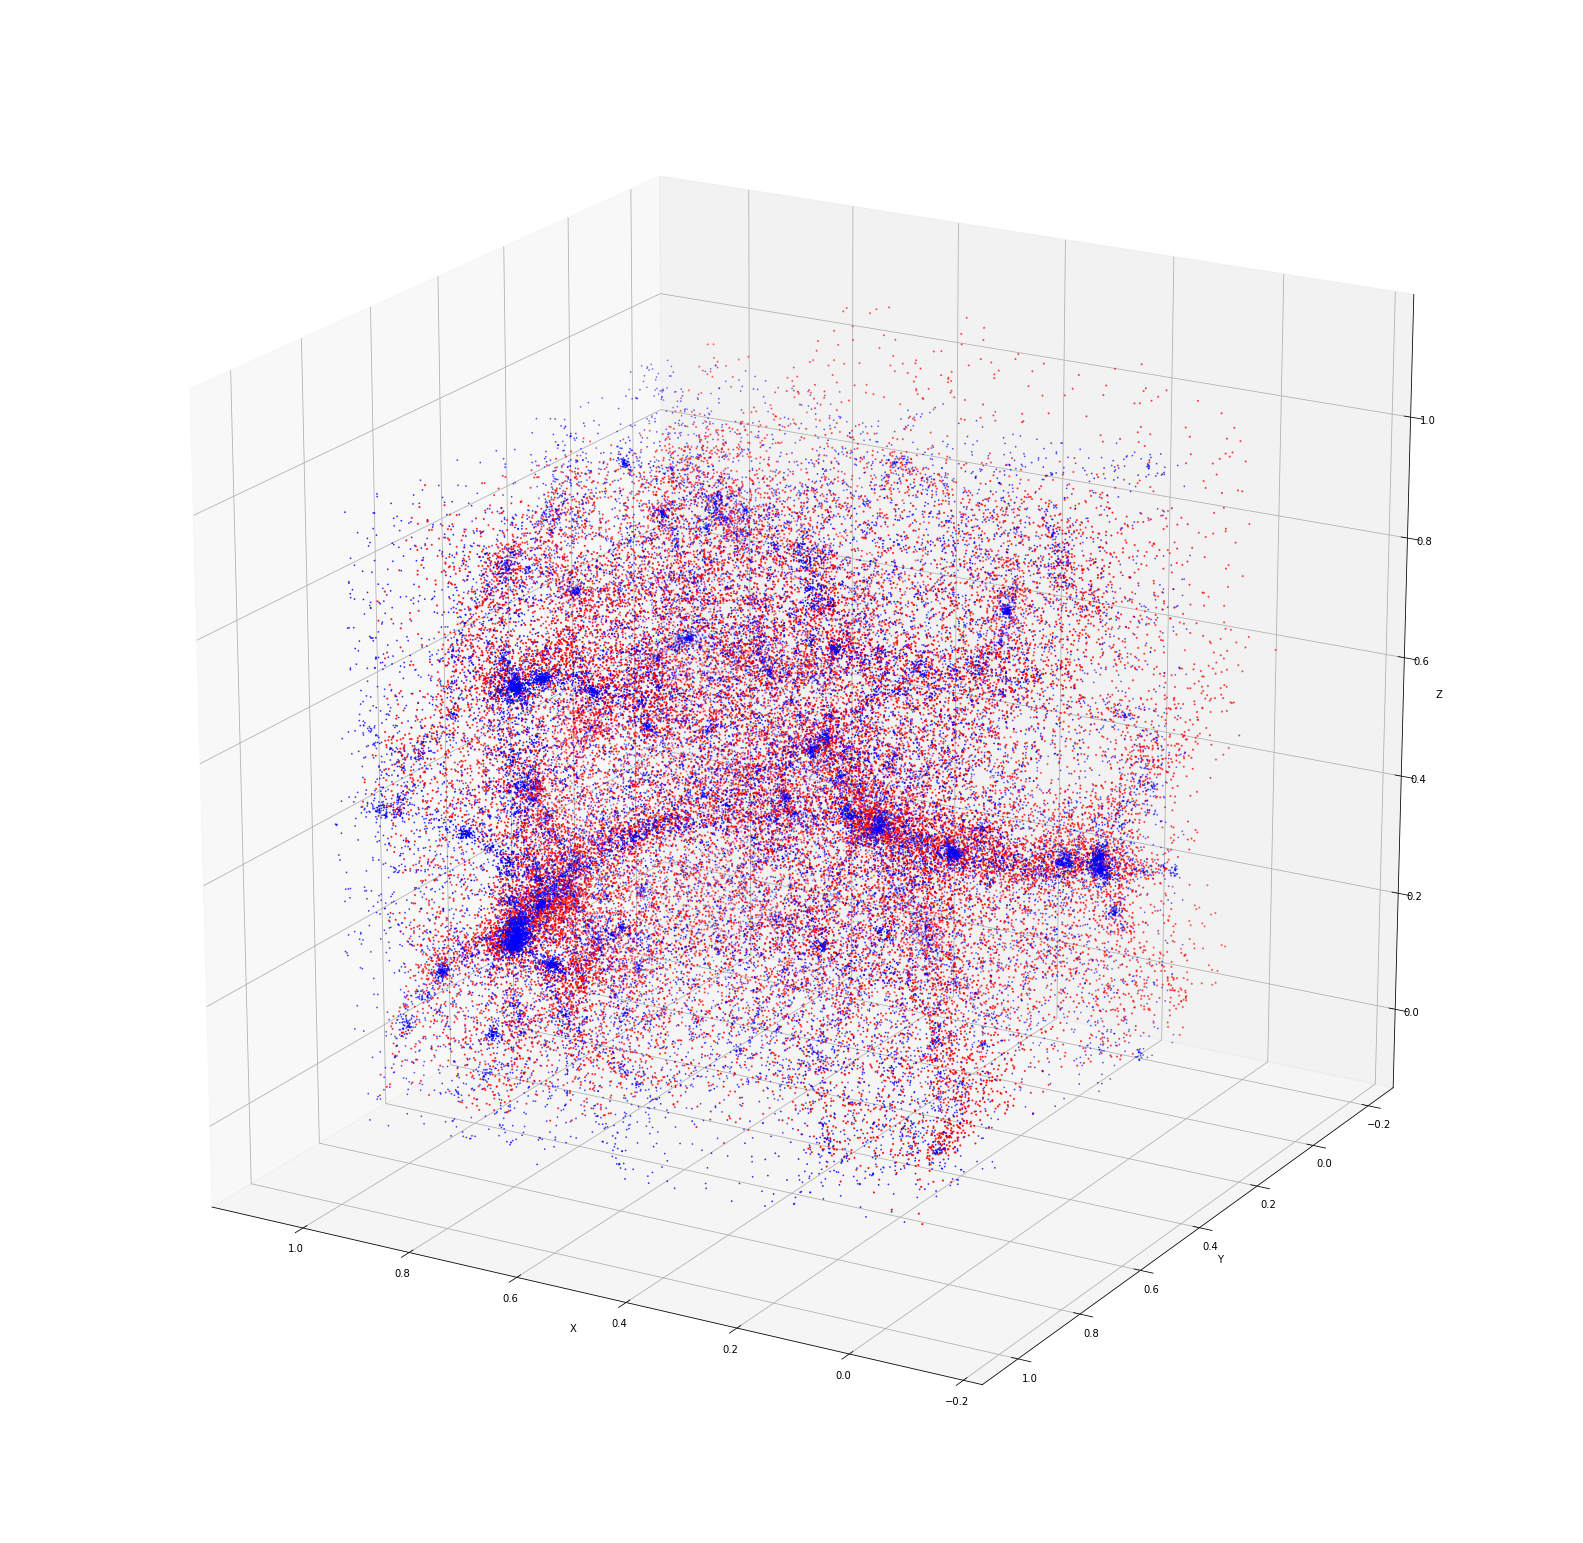

In [12]:
'''
plot point cloud
'''
j = 3
fsize = (28,28)
particle_size = (.6, 1.3)
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = data_utils.plot_3D_pointcloud(xt2, xh2, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image

In [19]:
np.sum(np.abs(xt[3,:,3:] - xt2[3,:,3:]))

34493.51

In [21]:
k = 21
np.sum(np.abs(xt[k,:,:3] - xt2[k,:,:3]))

0.0

In [22]:
for k in range(xt.shape[0]):
    cur = np.sum(np.abs(xt[k, :, :3] - xt2[k,:,:3]))
    if cur > 0:
        print('{}: {}'.format(k, cur))

In [4]:
data_dir = './SiyuCube/Cubes/'
data_all_path = '/home/evan/Data/nbody_simulations/ALL_32.npy'
X = np.load(data_all_path)
#Y = data_utils.normalize(np.copy(X))

In [5]:
x = X[:,:500]
X = None

In [7]:
y = data_utils.normalize(np.copy(x))

In [15]:
np.max(x[...,3:])

27.988237

In [14]:
np.max(y[...,3:])

35.412544

In [2]:
import glob
import struct
DATA_PATH = '/home/evan/Data/nbody_simulations/N_{0}/DM*/{1}_dm.z=0{2}000'


#=============================================================================
# Data utils
#=============================================================================
def read_sim(file_list, n_P):
    """ reads simulation data from disk and returns

    Args:
        file_list: (list<str>) paths to files
        n_P: (int) number of particles base (n_P**3 particles)
    """
    num_particles = n_P**3
    dataset = []
    for file_name in file_list:
        this_set = []
        with open(file_name, "rb") as f:
            for i in range(num_particles*6):
                s = struct.unpack('=f',f.read(4))
                this_set.append(s[0])
        dataset.append(this_set)
    dataset = np.array(dataset).reshape([len(file_list),num_particles,6]).astype(np.float32)
    return dataset

def load_datum(n_P, redshift, normalize_data=False):
    """ loads two redshift datasets from proper data directory

    Args:
        redshift: (float) redshift
        n_P: (int) base of number of particles (n_P**3 particles)
    """
    N_P = 10000 if n_P == 32 else 1000
    glob_paths = glob.glob(DATA_PATH.format(N_P, 'xv', redshift))
    X = read_sim(glob_paths, n_P)
    if normalize_data:
        X = normalize(X)
    return X

def load_data(n_P, *args, **kwargs):
    """ loads datasets from proper data directory
    # note: this function is redundant

    Args:
        n_P: (int) base of number of particles (n_P**3 particles)
    """
    data = []
    for redshift in args:
        x = load_datum(n_P, redshift, **kwargs)
        data.append(x)
    return data

In [3]:
# PROCESS USED TO CREATE FULL RS DATA
# DATA INTEGRITY WAS TESTED
DATA = load_data(16, 6.0, 4.0, 2.0, 1.5, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0, normalize_data=False)
print('DATA[0].shape: {}'.format(DATA[0].shape))

data_arr = np.zeros(((len(DATA),) + DATA[0].shape)).astype(np.float32)

for i in range(len(DATA)):
    data_arr[i] = DATA[i]
DATA = None
np.save('/home/evan/Data/nbody_simulations/ALL_16', data_arr)
data_arr.shape

DATA[0].shape: (1000, 4096, 6)


(11, 1000, 4096, 6)

In [10]:
np.max(data_arr[0,13,:,3:])

1.3419684

In [2]:
X = np.load('/home/evan/Data/nbody_simulations/ALL_16.npy')

In [3]:
X.shape

(11, 1000, 4096, 6)

In [16]:
X = data_utils.normalize(X)

In [17]:
import graph_ops

In [18]:
x0 = X[0, :8]

In [19]:
knn4 = graph_ops.KNN(x0, 14, 4)

In [20]:
knn1 = graph_ops.KNN(x0, 14, 1)

In [25]:
knn1.adjacency_list == knn4.adjacency_list

array([[[ True,  True, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True, False, False, ..., False, Fal

In [3]:
def get_bounded(x, bound):
    # need to select xp based on x array module
    lower, upper = bound
    return np.all(np.logical_and(lower<x, x<upper),axis=-1)

def get_bounded_MSE(x_hat, x_true, boundary):
    x_hat_loc  = x_hat[...,:3]
    x_true_loc = x_true[...,:3]
    bidx = get_bounded(x_true_loc, boundary)
    bhat = x_hat_loc[bidx]
    btrue = x_true_loc[bidx]
    return np.mean(np.sum(np.square(bhat - btrue), axis=-1))

In [5]:
x_input = np.load('../final_nbody/MultiCubes/Cubes/X_32_data.npy')
x_target = np.load('../final_nbody/SiyuCube/Cubes/X_32_0.0_data.npy')

In [6]:
velocity_coeff = np.load('./Data/velocity_coefficients_32.npy').item()

In [7]:
from chainer.serializers import load_npz
GRAPH_CHANNELS = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 6]
model = models.RSModel(GRAPH_CHANNELS, layer=models.GraphModel, vel_coeff=velocity_coeff)
model_save_path = './Model/RGL_32_60-00/RGL_32_60-00.model'
load_npz(model_save_path, model)
#if use_gpu: model.to_gpu()

In [9]:
# validation
validation_loss_history = np.zeros((x_input.shape[0]))
#predictions = np.zeros((X_val.shape[:-1] + (3,))).astype(np.float32)
#save_path = './MultiCubes/current_predictions/'
with chainer.using_config('train', False):
    for val_iter in range(x_target.shape[0]):
        _val_in   = x_input[val_iter:val_iter+1]
        _val_true = x_target[val_iter:val_iter+1]
        val_in, val_true = chainer.Variable(_val_in), chainer.Variable(_val_true)
        
        val_hat, predictions = model.fwd_target(val_in, (0,10))
        val_loss = nn.bounded_mean_squared_error(val_hat, val_true)
        validation_loss_history[val_iter] = cuda.to_cpu(val_loss.data)
        #predictions[val_iter] = cuda.to_cpu(val_hat.data)
        print('{:<3}: {:.8}'.format(val_iter, validation_loss_history[val_iter]))
    #np.save(save_path +  'val_loss', validation_loss_history)
    #np.save(save_path + 'predictions_0600', predictions)
    print('validation avg {}'.format( np.median(validation_loss_history)))

0  : 0.0022738229
1  : 0.0048913895
2  : 0.00251078
3  : 0.0016400415
4  : 0.0024363881
5  : 0.0021184862
6  : 0.0024587559
7  : 0.0018190092
8  : 0.0025070771
9  : 0.003221289
10 : 0.0034686348
11 : 0.0018817198


KeyboardInterrupt: 